# 0. Import libraries

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.figsize"] = [12,6]

# 1. Load data
In this notebook, we show an example of scRNA-seq preprocessing using scRNA-seq data of hematopoiesis (Paul, F., Arkin, Y., Giladi, A., Jaitin, D. A., Kenigsberg, E., Keren-Shaul, H., et al. (2015). Transcriptional Heterogeneity and Lineage Commitment in Myeloid Progenitors. Cell, 163(7), 1663–1677. http://doi.org/10.1016/j.cell.2015.11.013).
This data can be download using a scanpy's function.

Please change the code below if you want to use your data.

In [3]:
# download dataset. You can change the code blow if you use another data.
adata = sc.datasets.paul15()

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, making a copy.


# 2. Filtering

In [4]:
# only consider genes with more than 1 count
sc.pp.filter_genes(adata, min_counts=1)


# 3. Normalization

In [5]:
# normalize gene expression matrix with total UMI count per cell
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')

# 4. Variable gene detection
In celloracle we will make GRN and do simulation using many genes.
Removing weakly-variable gene genes will reduce calculation time. We recomend using top 2000~3000 variable genes. 

In [6]:
# select top2000 highly-variable genes
filter_result = sc.pp.filter_genes_dispersion(adata.X,
                                              flavor='cell_ranger',
                                              n_top_genes=2000,
                                              log=False)

# subset the genes
adata = adata[:, filter_result.gene_subset]

# renormalize after filtering
sc.pp.normalize_per_cell(adata)

Trying to set attribute `.obs` of view, making a copy.


# 5. Log transformation
Log transformation and scaling are necessary for many single cell analysis.
But we still use non-transformed gene expression data in the celloracle analysis.
We keep raw count in anndata with following command.

In [7]:
# keep raw cont data before log transformation
adata.raw = adata

# Log transformation and scaling
sc.pp.log1p(adata)
sc.pp.scale(adata)

In [8]:
# (optional) Regressing out some values help reduce batch effects.

#sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
#sc.pp.regress_out(adata, ['n_counts'])

# 6. Dimensional reduction
Dimensional reduction is one of the most important parts in the scRNA-seq analysis.
In celloracle, we use dimensional reduction embeddings for the simulation of cell transition.
We need to select an algorithm for dimensional reduction so that cell-cell relationship is properly represented.
We recommend using one of the dimensional reduction algorithms (or trajectory inference algorithms); UMAP, tSNE, diffusion map, Force-directed graph drawing, PAGA.

In this example, we use a combination of diffusion, force-directed graph drawing, and PAGA.

In [9]:
# PCA
sc.tl.pca(adata, svd_solver='arpack')

In [10]:
# diffusion map
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)

sc.tl.diffmap(adata)
# calculate neihbors again based on diffusionmap 
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

# 7. Clustering

In [11]:
sc.tl.louvain(adata, resolution=0.8)

# (Optional) Re-calculate Dimensional reduction graph

In [12]:
# PAGA graph construction
sc.tl.paga(adata, groups='louvain')

In [13]:
# check current cluster name
cluster_list = adata.obs.louvain.unique()
cluster_list

[5, 2, 12, 13, 0, ..., 6, 20, 14, 15, 21]
Length: 23
Categories (23, object): [5, 2, 12, 13, ..., 20, 14, 15, 21]

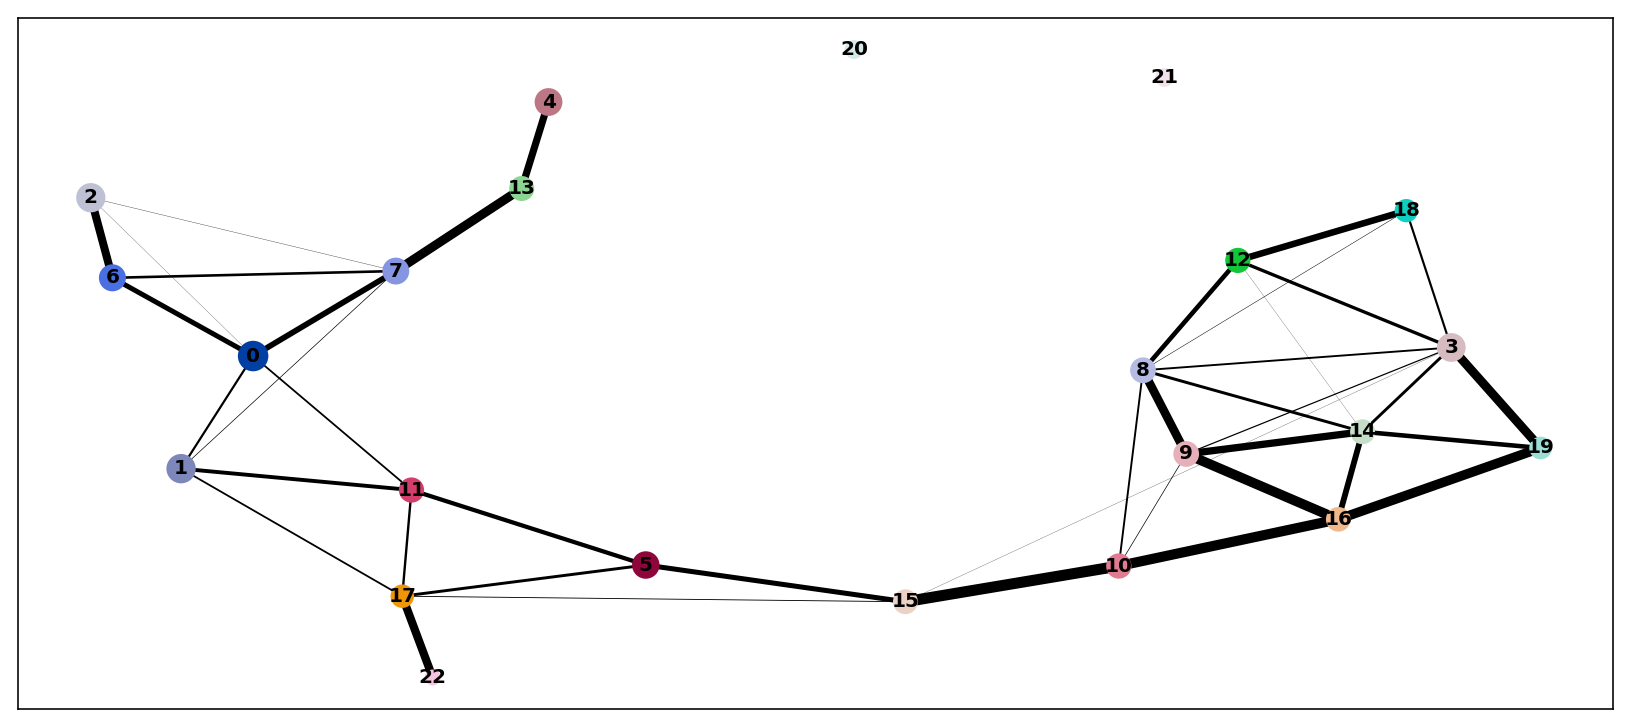

In [14]:
sc.pl.paga(adata)

In [15]:
sc.tl.draw_graph(adata, init_pos='paga', random_state=123)

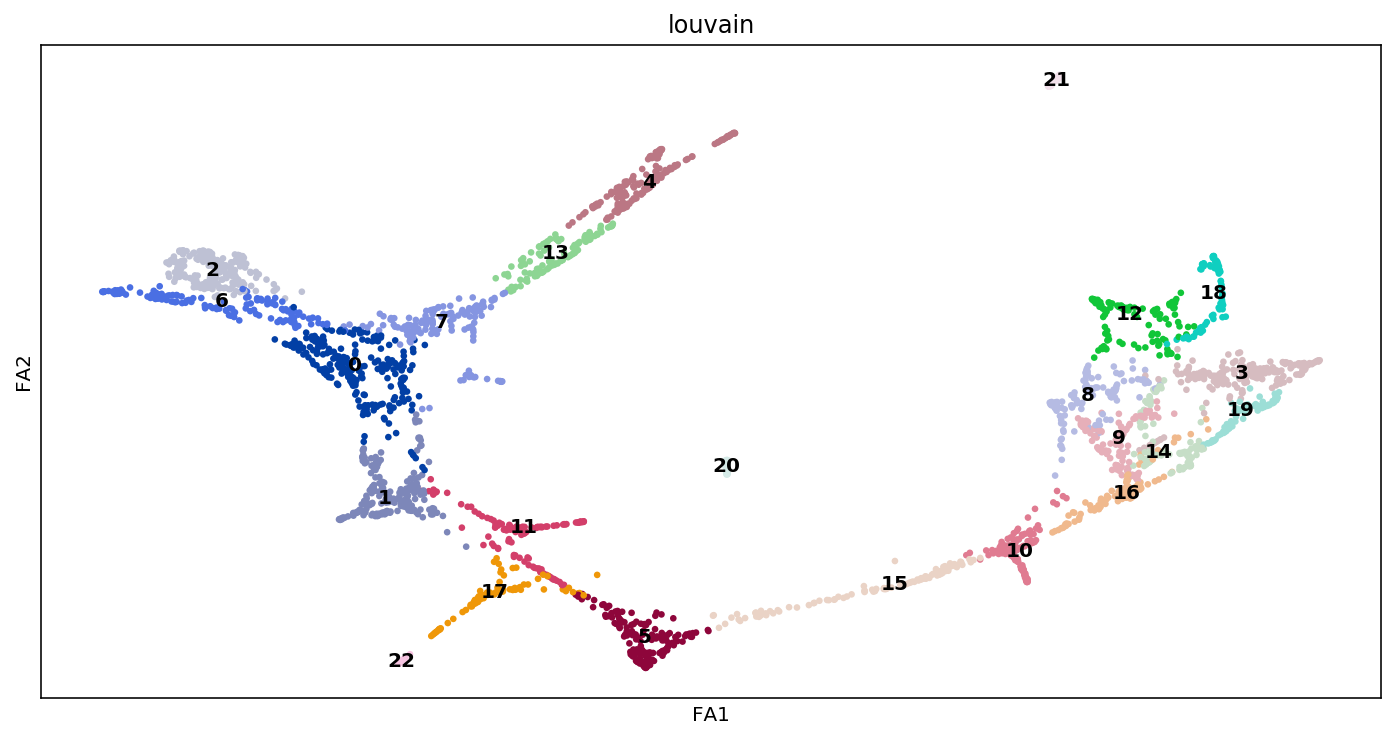

In [16]:
sc.pl.draw_graph(adata, color=['louvain'],
                 legend_loc='on data')

# 8. Check data
## 8.1. Visualize marker gene expression

marker gene of Erythroids


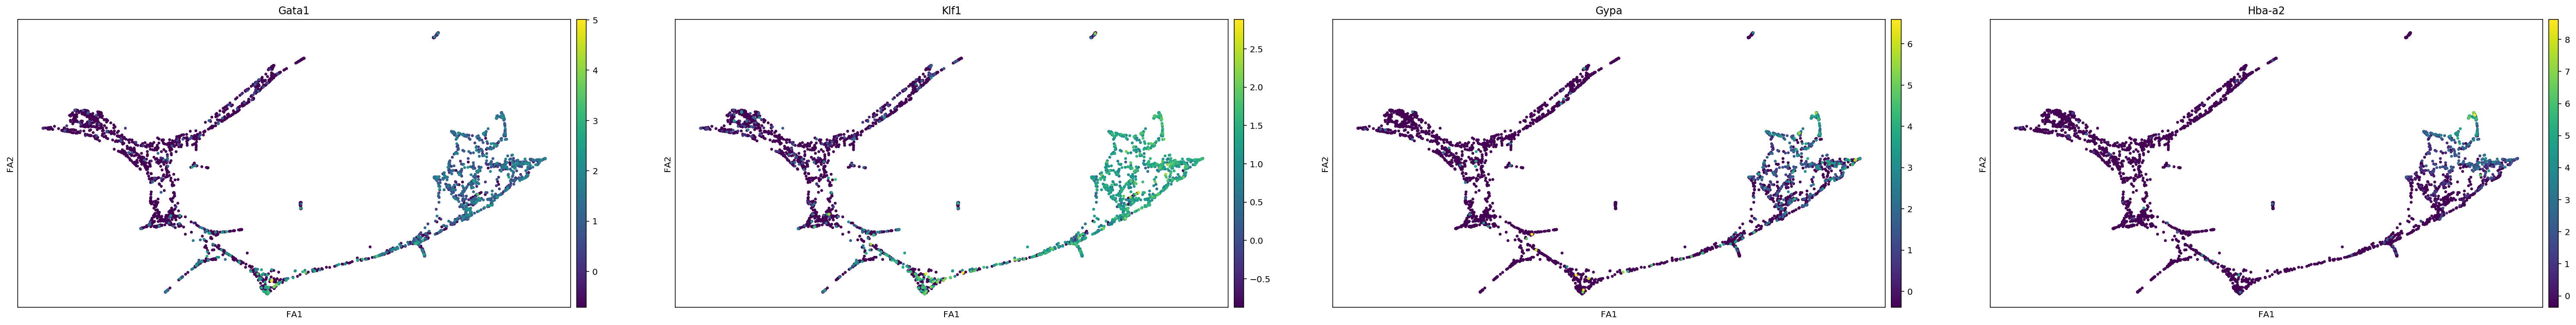

marker gene of Megakaryocytes


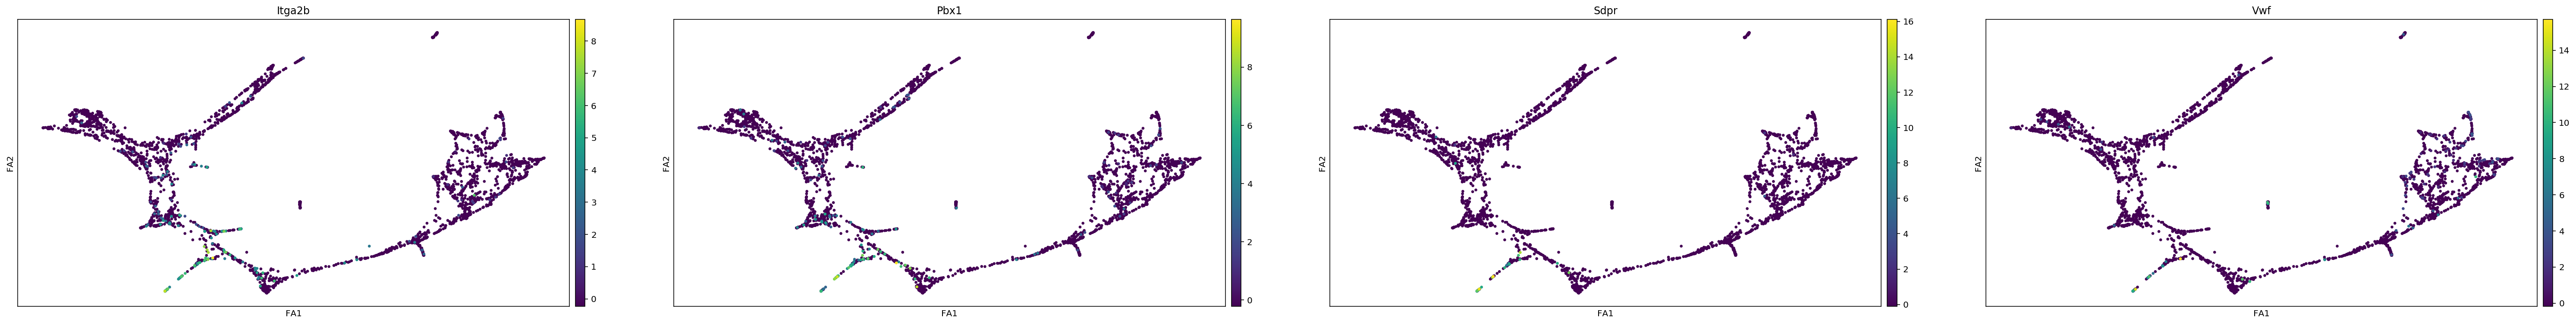

marker gene of Granulocytes


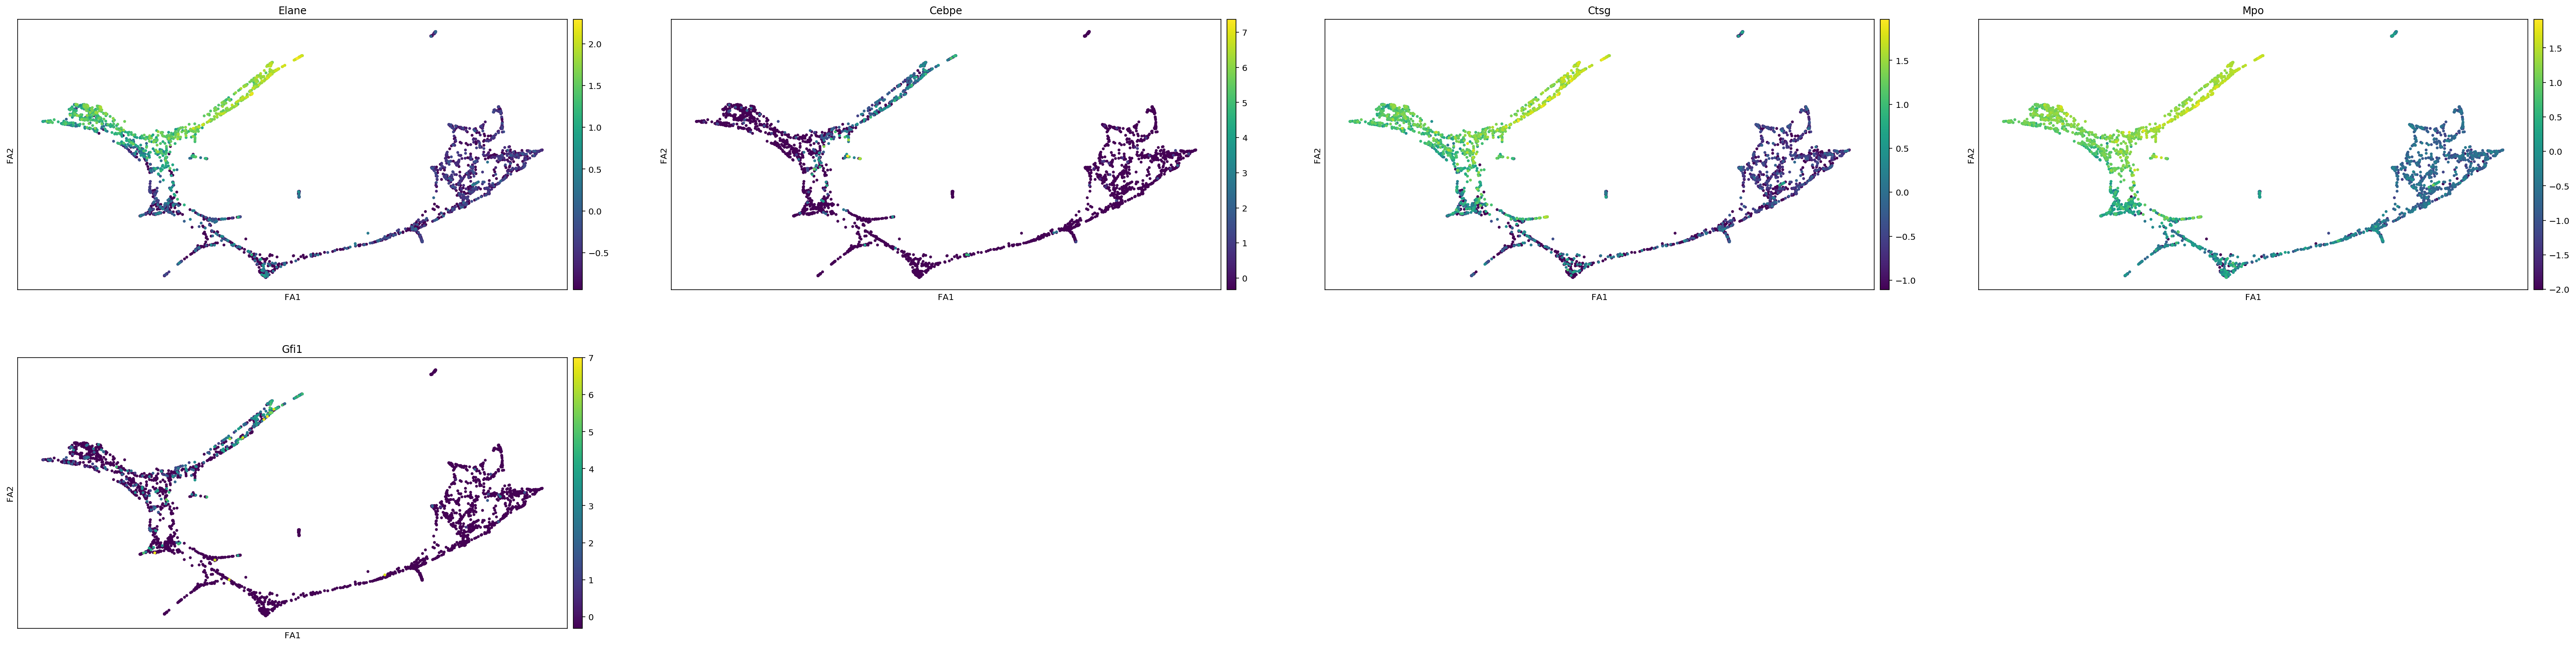

marker gene of Monocytes


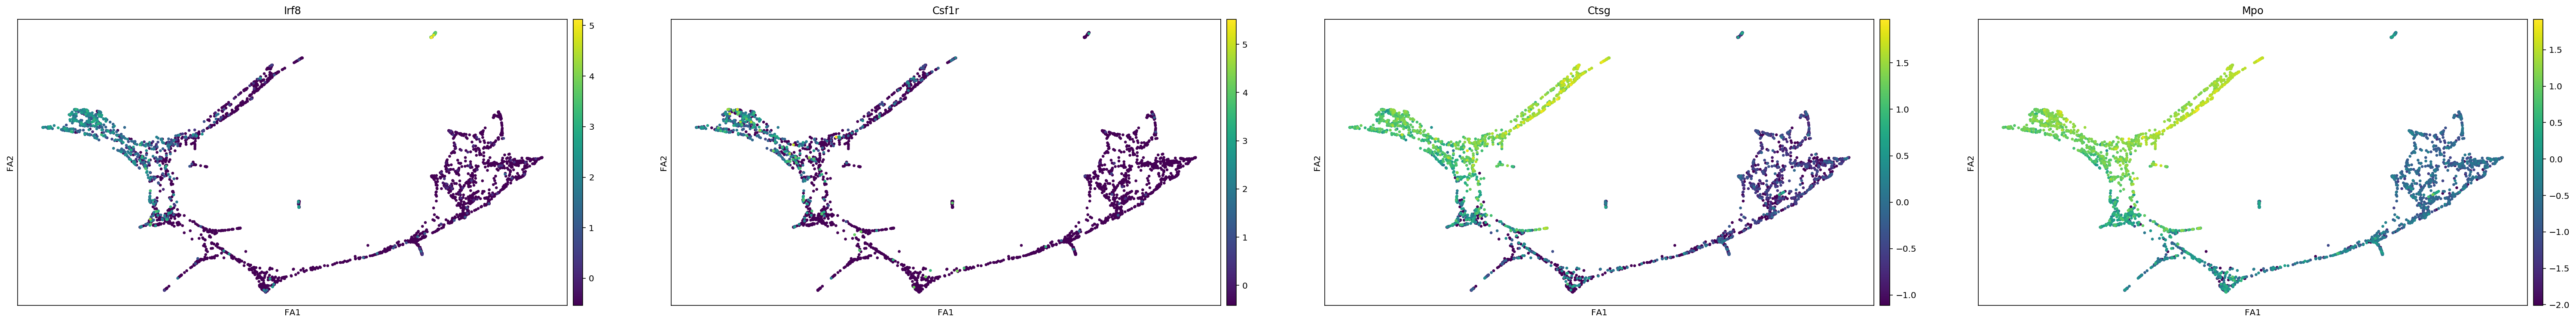

marker gene of Mast_cells


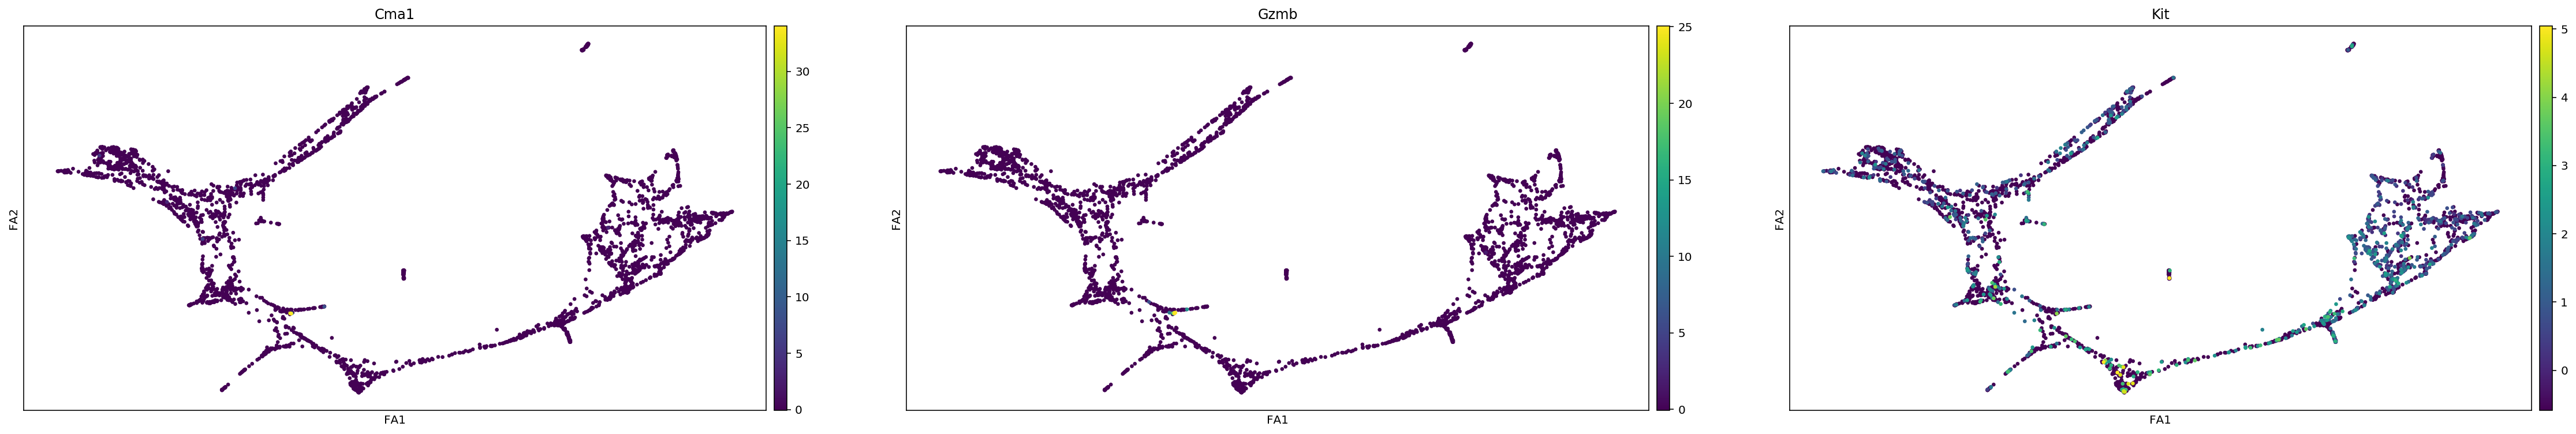

marker gene of Basophils


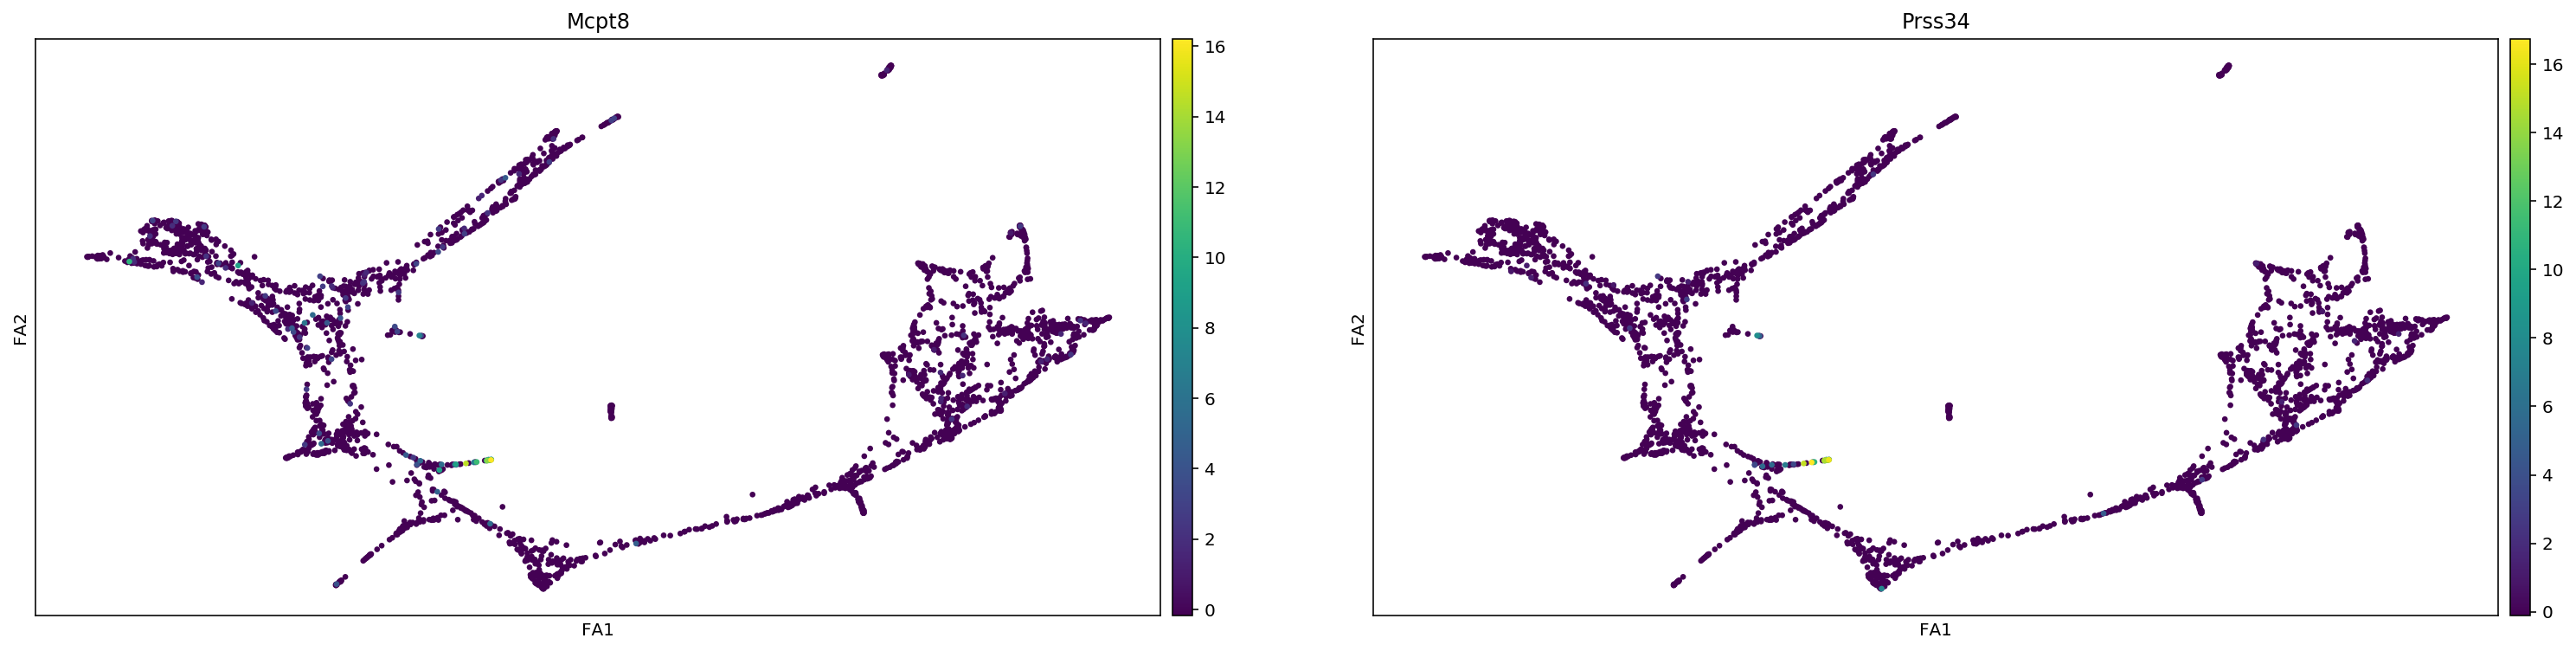

In [17]:
markers = {"Erythroids":["Gata1", "Klf1", "Gypa", "Hba-a2"],
           "Megakaryocytes":["Itga2b", "Pbx1", "Sdpr", "Vwf"],
            "Granulocytes":["Elane", "Cebpe", "Ctsg", "Mpo", "Gfi1"],
            "Monocytes":["Irf8", "Csf1r", "Ctsg", "Mpo"],
            "Mast_cells":["Cma1", "Gzmb", "Kit"],
            "Basophils":["Mcpt8", "Prss34"]
            }

for cell_type, genes in markers.items():
    print(f"marker gene of {cell_type}")
    sc.pl.draw_graph(adata, color=genes, use_raw=False)
    plt.show()



# 8. Make annotation for cluster

Based on the marker gene expression and previous report, we will manually make annotation for each cluster.

## 8.1. Make annotation (1)

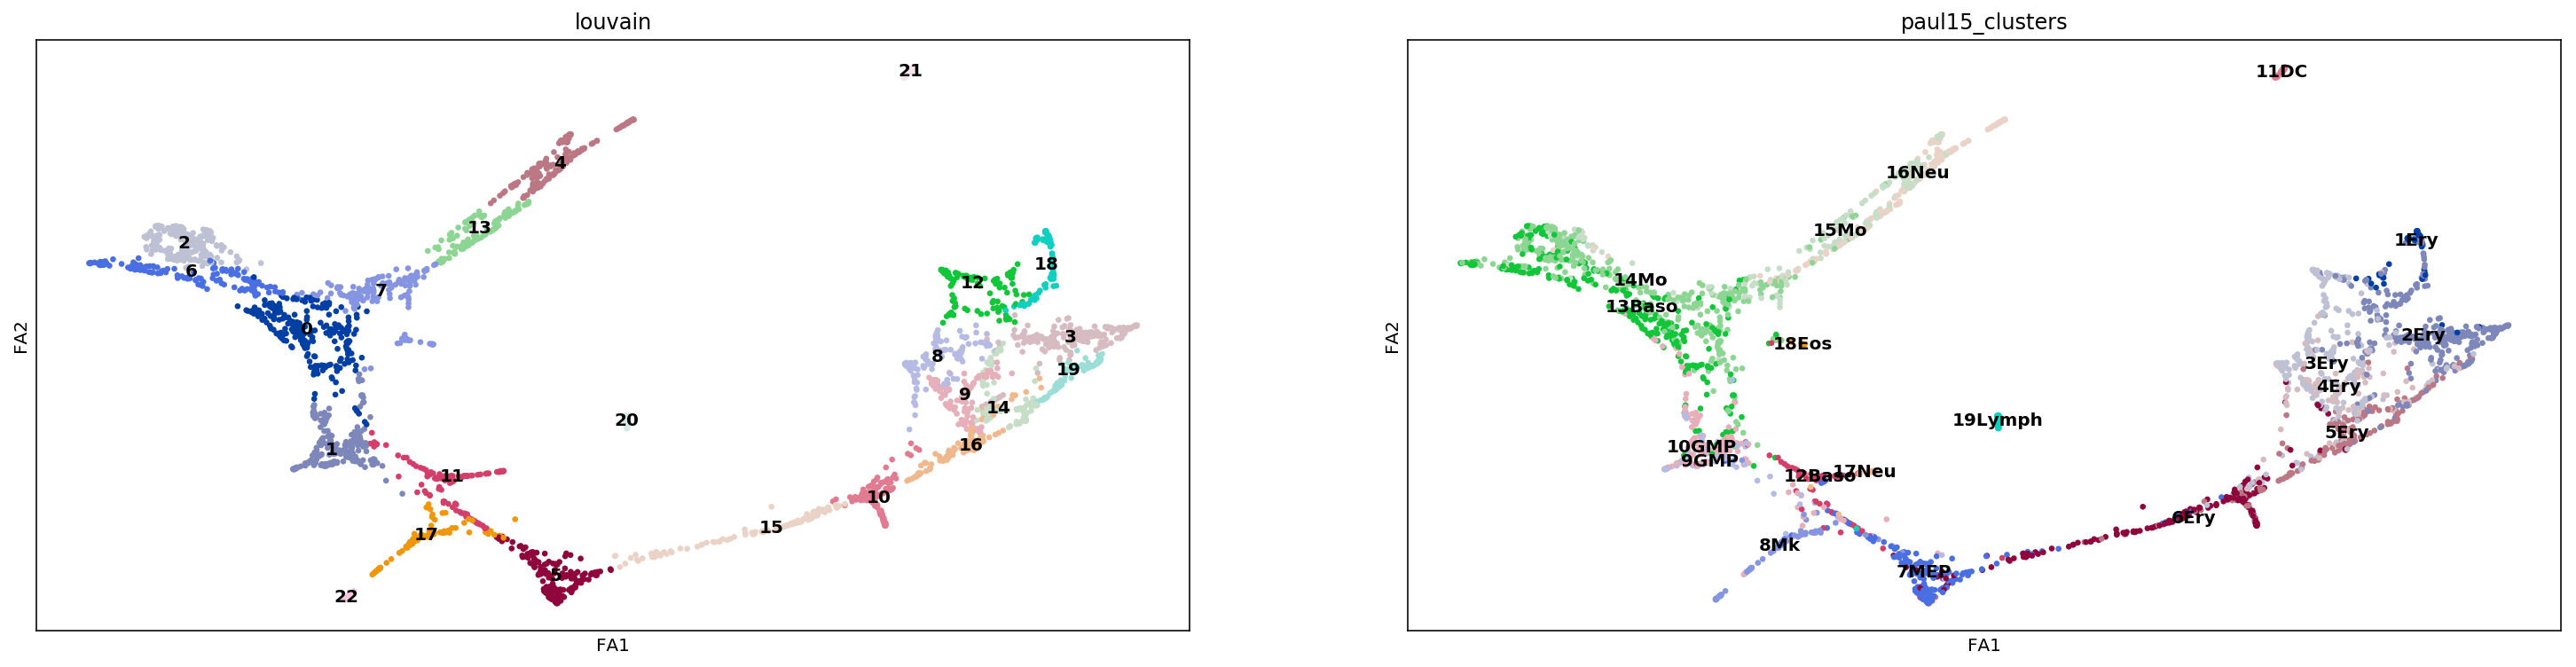

In [20]:
sc.pl.draw_graph(adata, color=['louvain', 'paul15_clusters'],
                 legend_loc='on data')

In [21]:
# check current cluster name
cluster_list = adata.obs.louvain.unique()
cluster_list

[5, 2, 12, 13, 0, ..., 6, 20, 14, 15, 21]
Length: 23
Categories (23, object): [5, 2, 12, 13, ..., 20, 14, 15, 21]

In [22]:
# make anottation dictionary
annotation = {"MEP":[5],
              "Erythroids": [15, 10, 16, 9, 8, 14, 19, 3, 12, 18],
              "Megakaryocytes":[17, 22],  
              "GMP":[11, 1],
              "late_GMP" :[0],   
              "Granulocytes":[7, 13, 4],
              "Monocytes":[6, 2],
              "DC":[21],
              "Lymphoid":[20]}

# change dictionary format
annotation_rev = {}
for i in cluster_list:
    for k in annotation:
        if int(i) in annotation[k]:
            annotation_rev[i] = k
            
# check dictionary
annotation_rev

{'5': 'MEP',
 '2': 'Monocytes',
 '12': 'Erythroids',
 '13': 'Granulocytes',
 '0': 'late_GMP',
 '10': 'Erythroids',
 '3': 'Erythroids',
 '18': 'Erythroids',
 '11': 'GMP',
 '7': 'Granulocytes',
 '8': 'Erythroids',
 '22': 'Megakaryocytes',
 '16': 'Erythroids',
 '1': 'GMP',
 '17': 'Megakaryocytes',
 '4': 'Granulocytes',
 '19': 'Erythroids',
 '9': 'Erythroids',
 '6': 'Monocytes',
 '20': 'Lymphoid',
 '14': 'Erythroids',
 '15': 'Erythroids',
 '21': 'DC'}

In [23]:
adata.obs["cell_type"] = [annotation_rev[i] for i in adata.obs.louvain]

... storing 'cell_type' as categorical


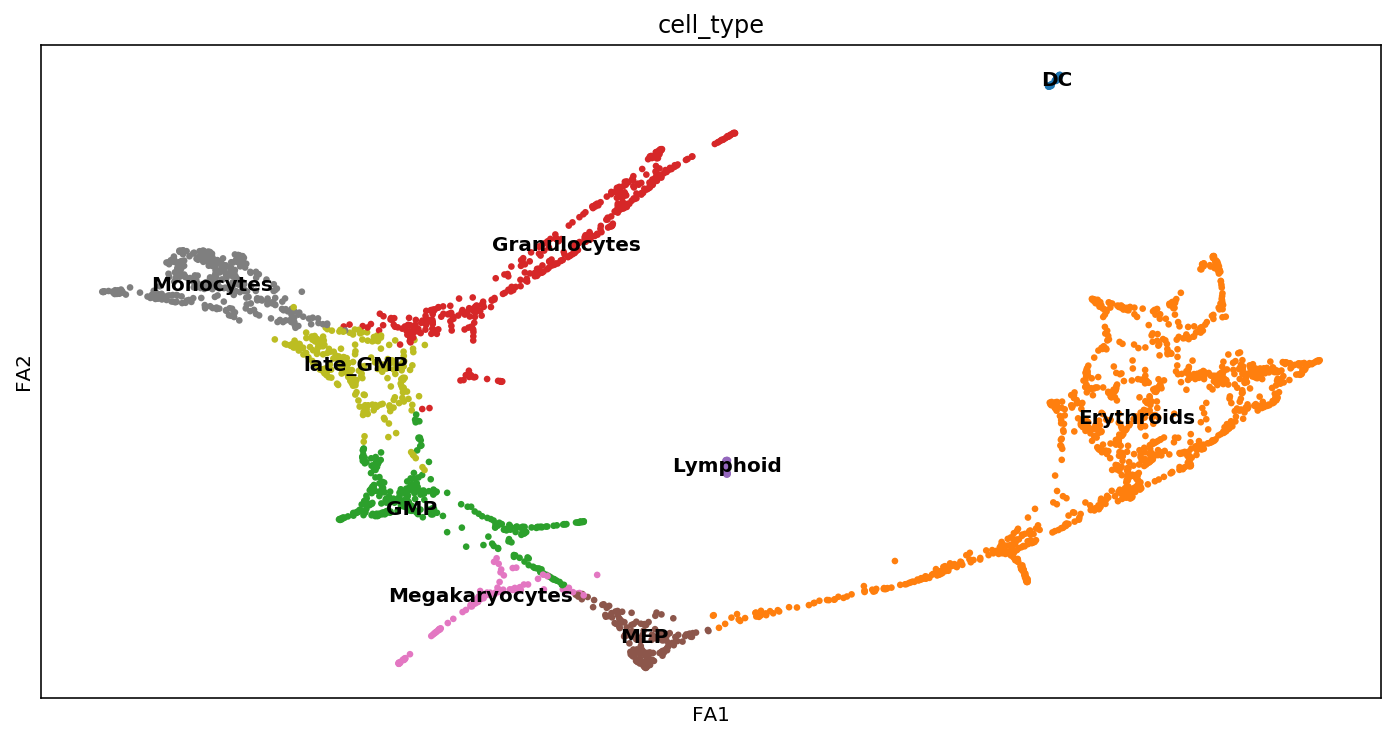

In [24]:
# check results
sc.pl.draw_graph(adata, color=['cell_type'],
                 legend_loc='on data')

## 8.2. Make annotation (2)
We'll make another annotation manually for each louvain clusters

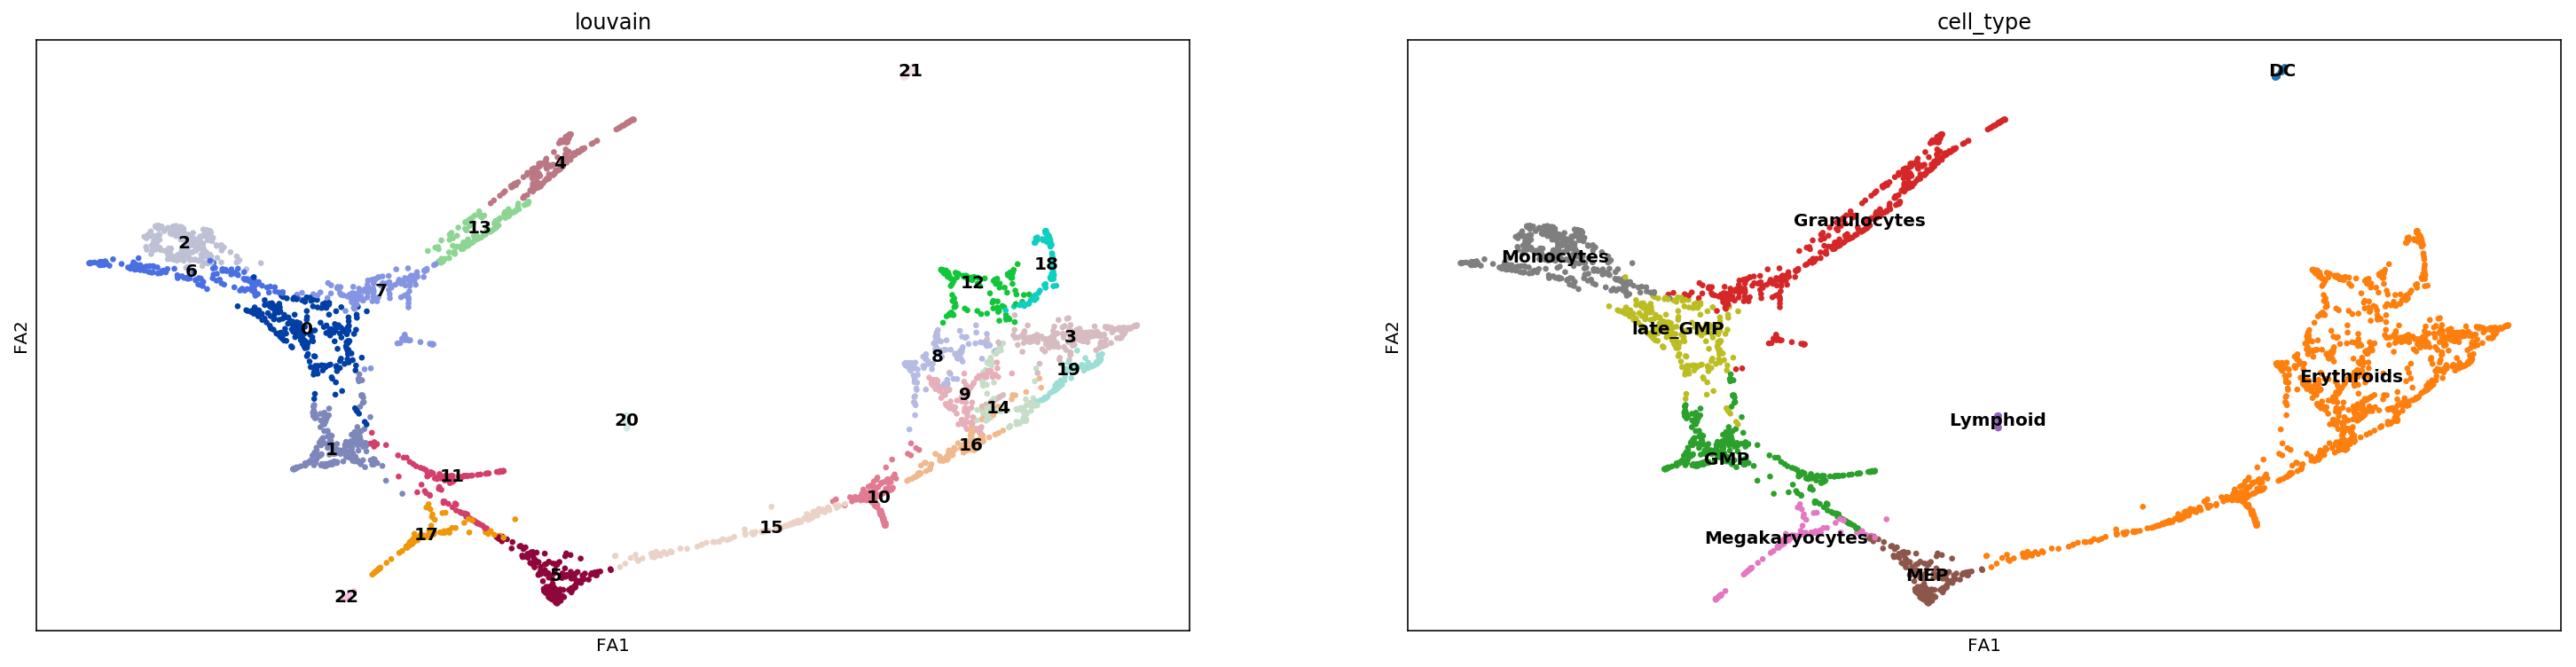

In [25]:
sc.pl.draw_graph(adata, color=['louvain', 'cell_type'],
                 legend_loc='on data')

In [26]:
annotation_2 = {'5': 'MEP_0',
                '15': 'Ery_0',
                '10': 'Ery_1',
                '16': 'Ery_2',
                '14': 'Ery_3',
                '9': 'Ery_4',
                '8': 'Ery_5',
                '19': 'Ery_6',
                '3': 'Ery_7',
                '12': 'Ery_8',
                '18': 'Ery_9',
                '17': 'Mk_0',
                '22': 'Mk_0',
                '11': 'GMP_0',
                '1': 'GMP_1',
                '0': 'GMPl_0',
                '7': 'Gran_0',
                '13': 'Gran_1',
                '4': 'Gran_2',
                '6': 'Mo_0',
                '2': 'Mo_1',
                '21': 'DC_0',
                '20': 'Lym_0'}

In [27]:
adata.obs["louvain_annot"] = [annotation_2[i] for i in adata.obs.louvain]

... storing 'louvain_annot' as categorical


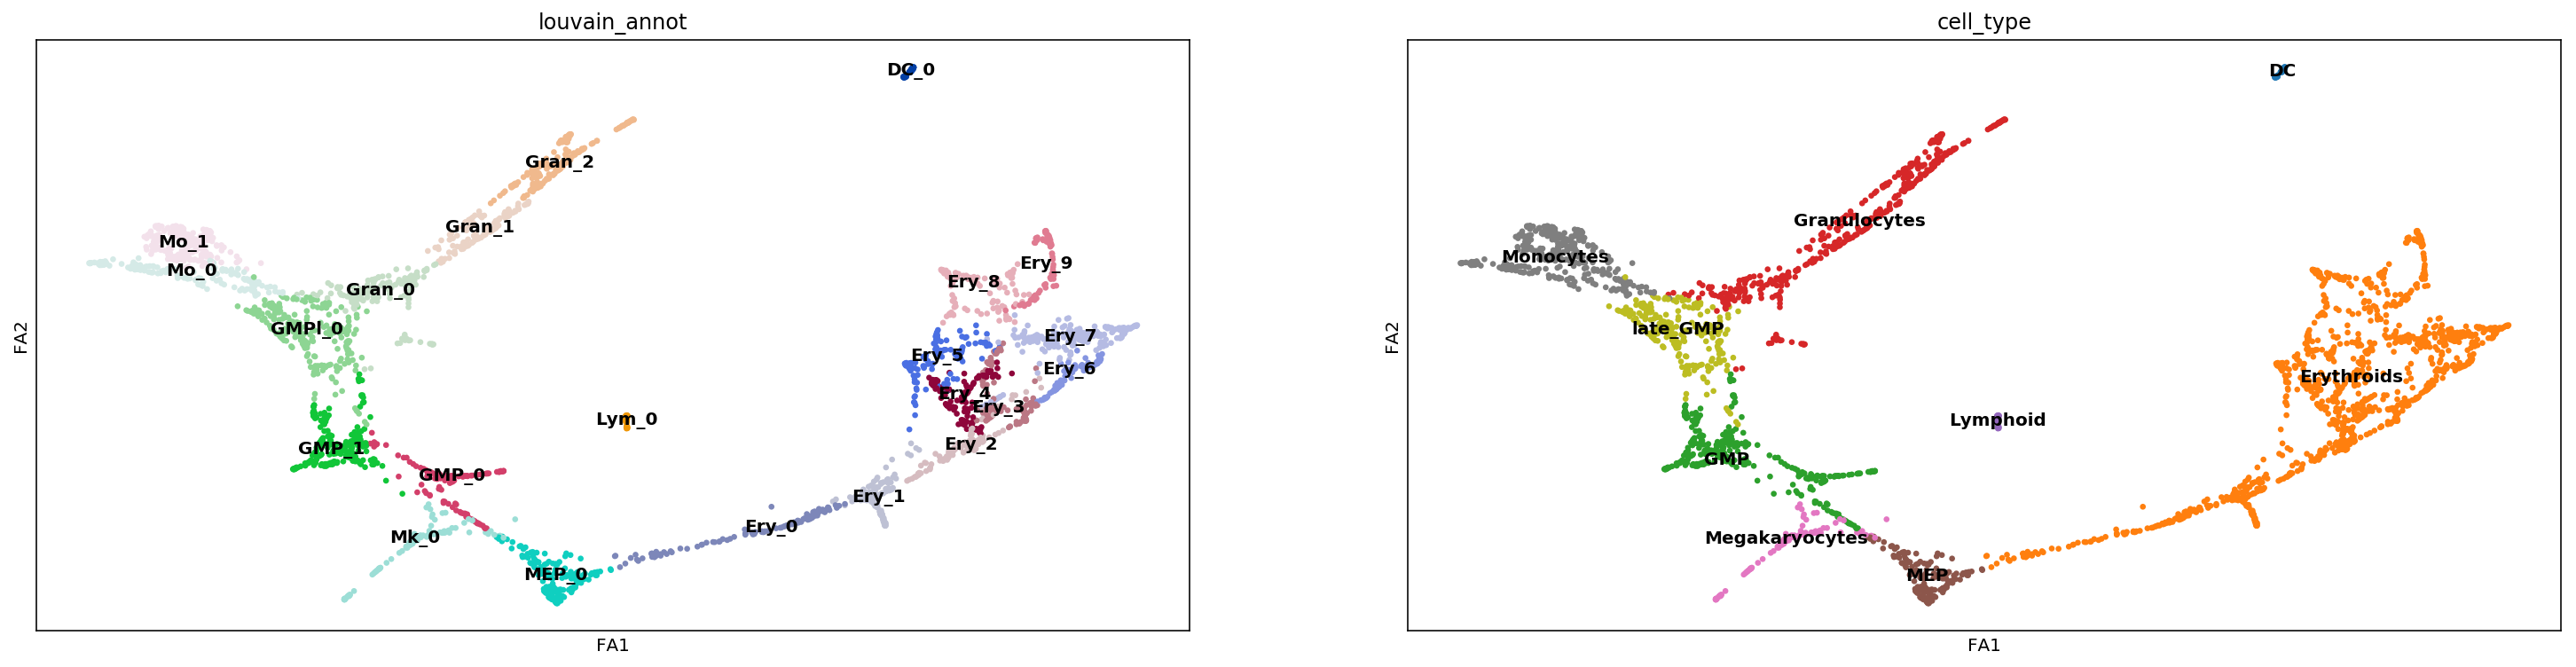

In [28]:
# check result
sc.pl.draw_graph(adata, color=['louvain_annot', 'cell_type'],
                 legend_loc='on data')

We've done secveral scRNA-preprocessing steps; filtering, normalization, clustering, dimensional reduction.
In the next step, we'll do GRN inference, network analysis, and in silico simulation based on these information.

# 9. (Option) Select cell cluster

In this tutorial, we are using scRNA-seq data of hematopoiesis. 
In the latter part, we will focus on the cell fate decision in the myeloid lineage. 
So we remove non-myeloid cell cluster, DC and Lymphoid now.


In [29]:
adata.obs.cell_type.unique()

[MEP, Monocytes, Erythroids, Granulocytes, late_GMP, GMP, Megakaryocytes, Lymphoid, DC]
Categories (9, object): [MEP, Monocytes, Erythroids, Granulocytes, ..., GMP, Megakaryocytes, Lymphoid, DC]

In [30]:
cell_of_interest = adata.obs.index[~adata.obs.cell_type.isin(["Lymphoid", "DC"])]
adata = adata[cell_of_interest, :]

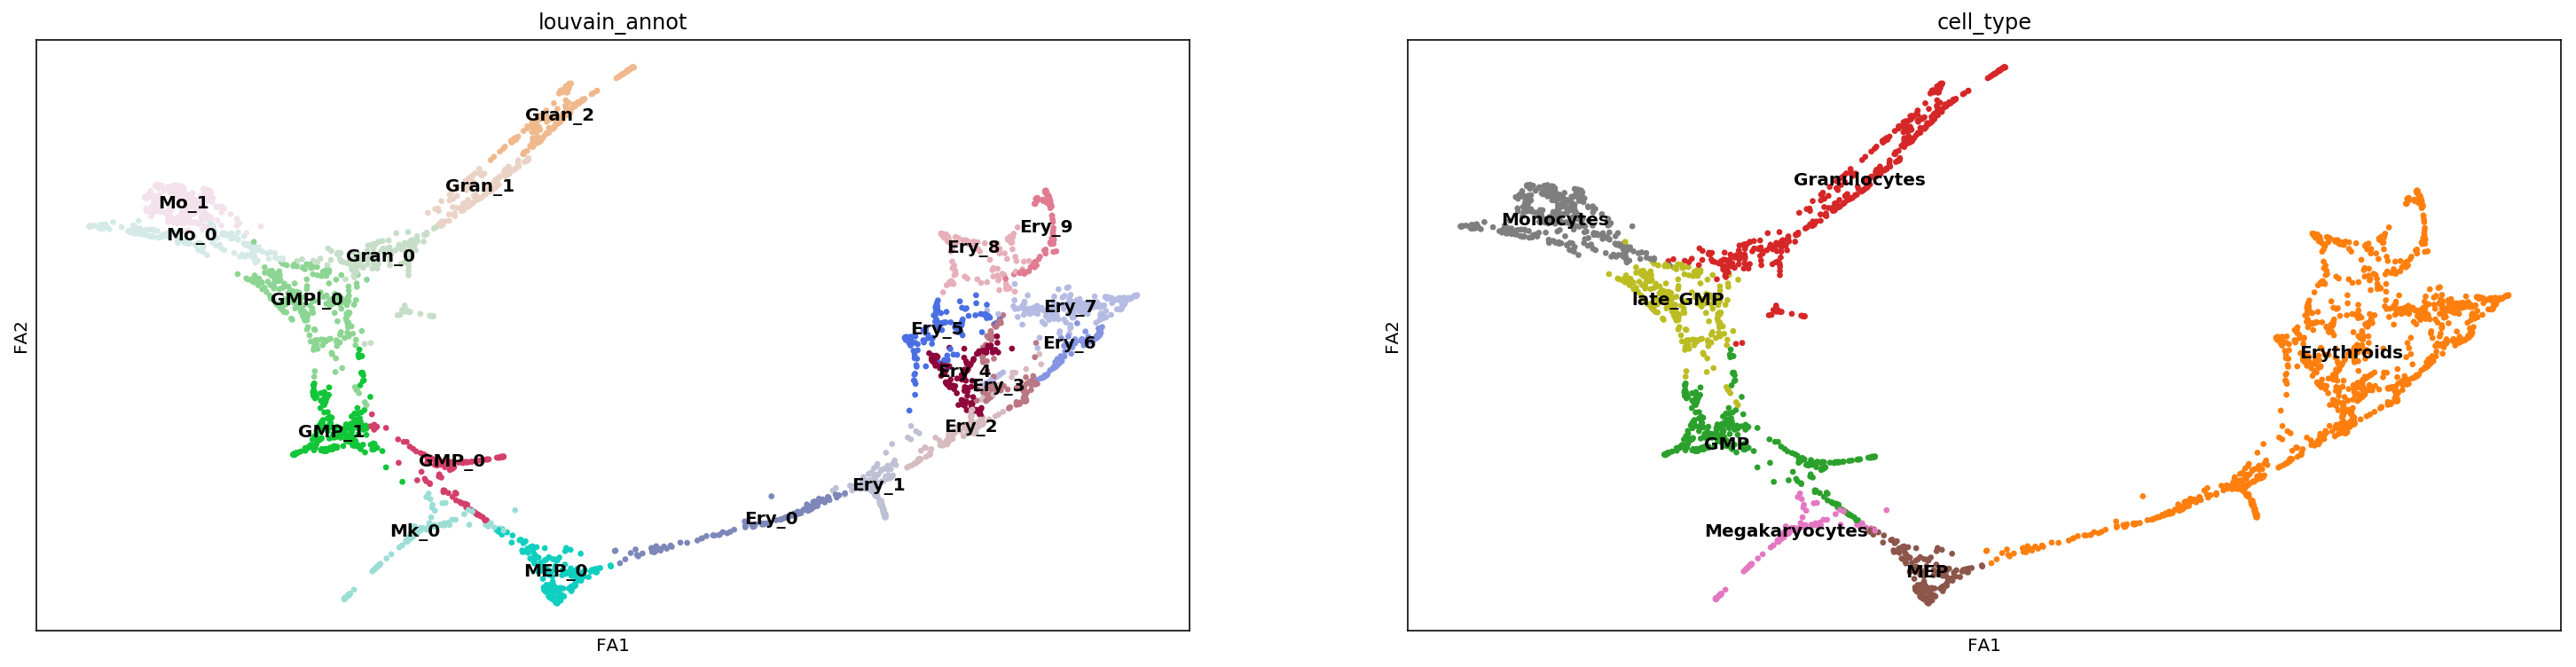

In [31]:
# check result
sc.pl.draw_graph(adata, color=['louvain_annot', 'cell_type'],
                 legend_loc='on data')

# 9. Save data

In [32]:
adata.write_h5ad("data/Paul_etal_15.h5ad")